# Deep learning project

by:
Pongsakorn Chanchaipol, 
Leelawadee Sirikul

The environment that we will choose is OpenAI's gym Acrobot environment.
Briefly explain, Acrobot is an environment consist of 2 connected-linear links which both links can rotate around its joint freely.

GOAL: reach the height of 1 (which is equal to length of one bar).

OBSERVATION (State): \[$\cos{\theta_1}, \sin{\theta_1}, \cos{\theta_2}, \sin{\theta_2} , \omega_1 , \omega_2$\], which $\theta_1$ and $\theta_2$ are the current angles of the links and $\omega_1$ and $\omega_2$ are the angular velocity of Acrobot's bars.



In [1]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from collections import namedtuple
import os
import time
import myplot
import my_qlearning, double_dqn, duel_dqn

Initialize environment and path variables:

In [2]:
#initialize environment and path variables
env = gym.make("Acrobot-v1")
env.seed(1)
torch.manual_seed(1)
np.random.seed(1)

Now, we build a function to compute height of the given state.
The original formula from the OpenAI gym's acrobat.py is:

$\qquad - \cos{\theta_1} - \cos{(\theta_1 + \theta_2)}$

But the state we got is in the form of ($\cos{\theta_1}, \sin{\theta_1}, \cos{\theta_2}, \sin{\theta_2} , \omega_1 , \omega_2$), which $\omega_1$ and $\omega_2$ are the angular velocity of both acrobat bars.

Since we don't have $\cos{(\theta_1 + \theta_2)}$, so we need to compute it by using this formula:

$\qquad  \cos{(\theta_1 + \theta_2)} = \cos{\theta_1}\cos{\theta_2} - \sin{\theta_1}\sin{\theta_2}$

Applying the previous formula, we can now calculate the height of the given state like below:

In [3]:
#return height of the given state
def get_height(state):
    cos_a, sin_a, cos_b, sin_b , _ , _ = state
    return -cos_a - (cos_a*cos_b - sin_a*sin_b)

## Random policy

Now, we will look at the performance of a random policy.
We will track the total rewards of each episodes and also the best height it can reach to see how good this policy is.

In [4]:
#random policy
best_episode_height = []
rewards = []
successful_steps = 0
num_episode = 1000

#episodes
for episode in range(num_episode):
    running_reward = 0
    env.reset()
    max_height = -2
    #steps
    for i in range(200):
        #do random action
        state, reward, done, _ = env.step(np.random.randint(0,3))
        running_reward += reward
        current_height = get_height(state)
        #success steps count
        if current_height>1:
            successful_steps += 1
        #update max_height
        if current_height > max_height:
            max_height = current_height
    rewards.append(running_reward)
    best_episode_height.append(max_height)
print("done!")

done!


The two plots below will show you the best height of each episode and total reward of each episode.

0

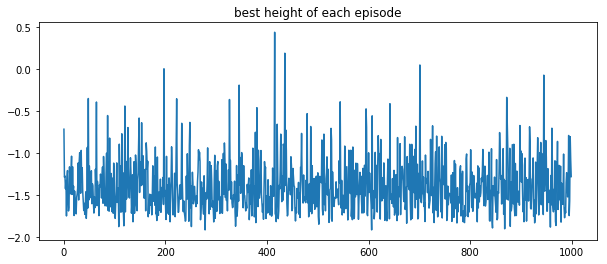

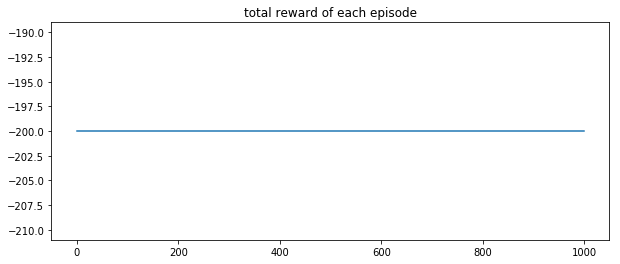

In [5]:
#plot to see the best height of each episode
myplot.plot_best_height(best_episode_height)

#plot to see the total reward of each episode
myplot.plot_total_reward(rewards)

From the results shown above, we can see that none of the episodes reach the goal height (height of 1). So, its total rewards are all at -200 since we will get a reward of -1 for each step we took and we have 200 steps per epoch.

## Q-learning

Now, we will try running Q-learning (implemented in "my_qlearning.py") on the Acrobot environment:

In [6]:
model1 = my_qlearning.QNN()
model1, best_episode_height, reward_history = my_qlearning.train(env,model1,episodes=1000)

100%|██████████| 1000/1000 [04:02<00:00,  3.66it/s]


successful episodes: 933 - 93.3000%


Let see the plot of the result we got from our Q-learning model above:

0

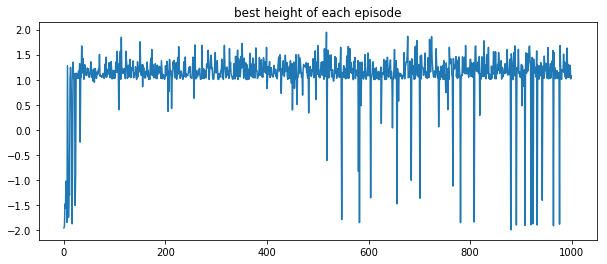

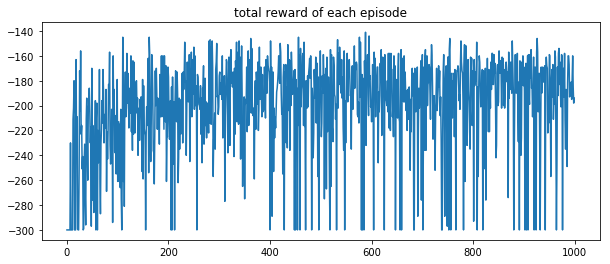

In [7]:
myplot.plot_best_height(best_episode_height)
myplot.plot_total_reward(reward_history)

We can see that our model can reach the goal at height 1 in a just few episodes of training, but it is very noisy and didn't perform well consistently. The reward plot is also the same. Total rewards jump from zero to a much better performance very fast but it is very noisy.

After we have seen the performance graph, we will try running our model in real-time and render out by running the cell below: 

(dash plot = sample runs, thick plot = average of all sample runs)

avg successful steps: 64.5 - 12.9000%
avg first successful step: 178.3 


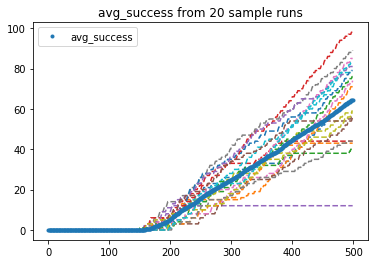

In [8]:
#set visualization to True to render the environment
QL_avg_success = myplot.test_run(env, model1, 20, n_steps=500, fps=30, visualization=False)

In order to dig deeper into how our Q-learning model act, we plot its policy out from a sampled set of pseudo-state.

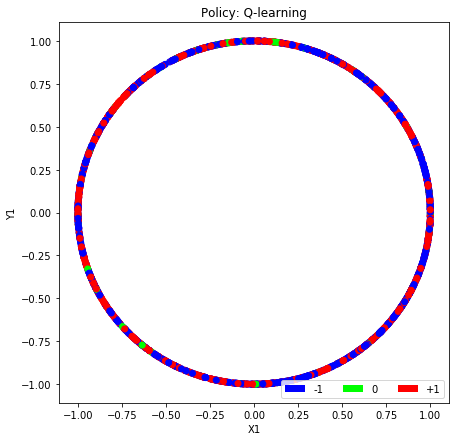

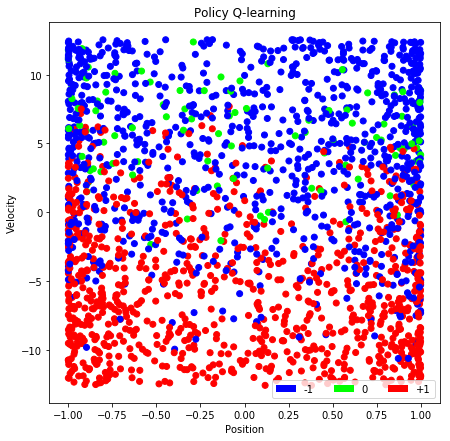

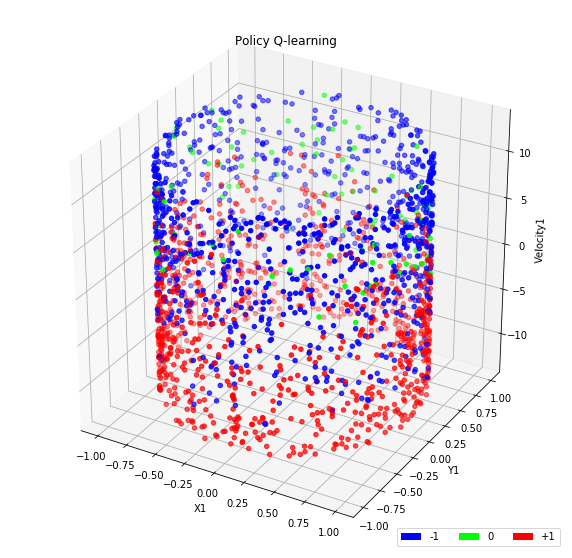

In [9]:
pseudo_states = myplot.prepare_plot_vars(model1, n_samples=2000)
fig1 = myplot.plot_top_down(*pseudo_states,"Q-learning")
fig2 = myplot.plot_side(*pseudo_states,"Q-learning")
fig3 = myplot.plot_3D(*pseudo_states,"Q-learning")

## Q-Learning with modify reward

We got an idea from internet that we can help our model learn faster or having a better performance model by modifying the reward function. Since we know that in the Acrobot environment, the higher the manitude of velocity, the faster that it will reach goal state, and that is what we're going to modify to the reward.

We will use the same model as before but we will change 3 things:
- Modify rewards so that it take angular velocity into account (previously it cares only the total height of the Acrobot). The reason of this modification is to encourage the model to increase the magnitude of angular velocity so that it reach goal more efficiently.
- Reduce the number of steps per episode to force the model to learn how to reach goal faster
- Increase number of episodes (model might need more epidsodes to learn how to reach goal when we reduced #steps)

In [10]:
model2 = my_qlearning.QNN()
model2, best_episode_height, reward_history = my_qlearning.train_mod_r(env,model2,steps=100,episodes=1000)

100%|██████████| 1000/1000 [02:00<00:00,  8.83it/s]


successful episodes: 347 - 34.7000%


0

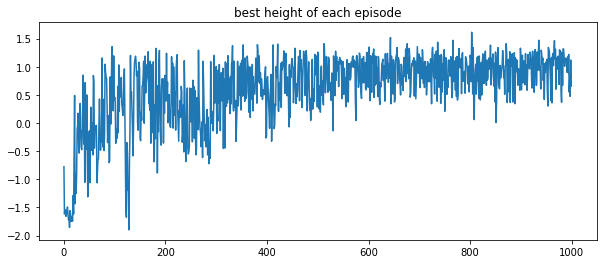

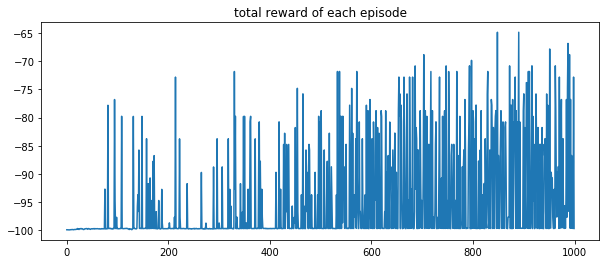

In [11]:
myplot.plot_best_height(best_episode_height)
myplot.plot_total_reward(reward_history)

avg successful steps: 80.6 - 16.1200%
avg first successful step: 101.95 


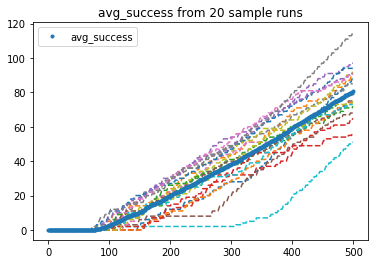

In [12]:
QL2_avg_success = myplot.test_run(env, model2, 20, n_steps=500, fps=30, visualization=False)

In [13]:
env.close()

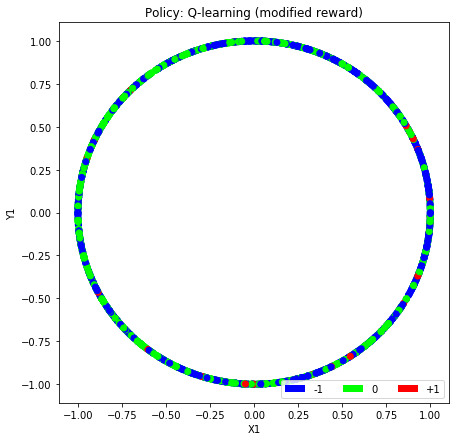

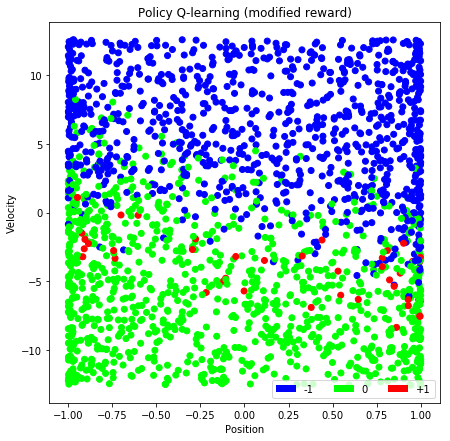

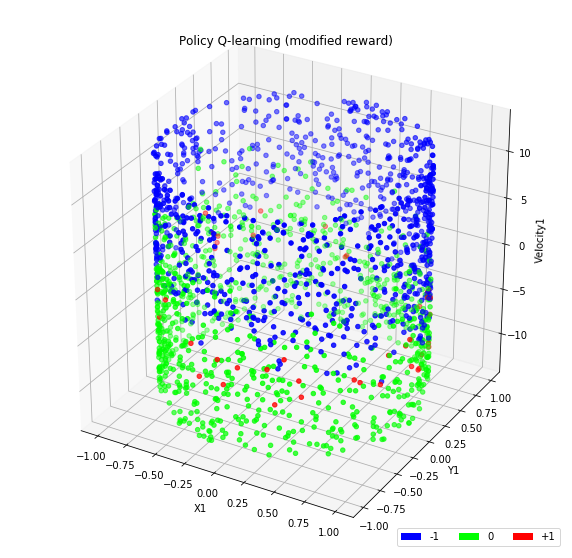

In [14]:
pseudo_states = myplot.prepare_plot_vars(model2, n_samples=2000)
fig1 = myplot.plot_top_down(*pseudo_states,"Q-learning (modified reward)")
fig2 = myplot.plot_side(*pseudo_states,"Q-learning (modified reward)")
fig3 = myplot.plot_3D(*pseudo_states,"Q-learning (modified reward)")

## Double Deep Q-Learning

Now, we will try using DDQN from HA3 to see if it will perform better than our previous models or not.

In [15]:
device = torch.device("cpu")
# Initializations
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]
num_episodes = 500
batch_size = 128
gamma = .94
learning_rate = 1e-4
enable_visualization = False
# Object holding our online / offline Q-Networks
ddqn = double_dqn.DoubleQLearningModel(device, num_states, num_actions, learning_rate)
replay_buffer = double_dqn.ExperienceReplay(device, num_states)

# Train
reward_history, best_episode_height = double_dqn.train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)

Episode: 0, Total Reward (running avg): -499 (-498.64) Epsilon: 0.999, Avg Q: 5.207e-08
Episode: 1, Total Reward (running avg): -498 (-498.63) Epsilon: 0.998, Avg Q: 4.539e-08
Episode: 2, Total Reward (running avg): -499 (-498.65) Epsilon: 0.997, Avg Q: -0.05867
Episode: 3, Total Reward (running avg): -499 (-498.66) Epsilon: 0.996, Avg Q: -0.1073
Episode: 4, Total Reward (running avg): -499 (-498.67) Epsilon: 0.995, Avg Q: -0.2093
Episode: 5, Total Reward (running avg): -499 (-498.70) Epsilon: 0.994, Avg Q: -0.3498
Episode: 6, Total Reward (running avg): -499 (-498.73) Epsilon: 0.993, Avg Q: -0.4119
Episode: 7, Total Reward (running avg): -498 (-498.71) Epsilon: 0.992, Avg Q: -0.2717
Episode: 8, Total Reward (running avg): -499 (-498.73) Epsilon: 0.991, Avg Q: -0.6066
Episode: 9, Total Reward (running avg): -499 (-498.74) Epsilon: 0.990, Avg Q: -0.5892
Episode: 10, Total Reward (running avg): -499 (-498.77) Epsilon: 0.989, Avg Q: -0.7733
Episode: 11, Total Reward (running avg): -499 (-

Episode: 189, Total Reward (running avg): -498 (-437.74) Epsilon: 0.810, Avg Q: -5.285
Episode: 190, Total Reward (running avg): -419 (-436.83) Epsilon: 0.809, Avg Q: -6.673
Episode: 191, Total Reward (running avg): -328 (-431.38) Epsilon: 0.808, Avg Q: -6.115
Episode: 192, Total Reward (running avg): -243 (-421.97) Epsilon: 0.807, Avg Q: -6.902
Episode: 193, Total Reward (running avg): -473 (-424.53) Epsilon: 0.806, Avg Q: -7.044
Episode: 194, Total Reward (running avg): -279 (-417.26) Epsilon: 0.805, Avg Q: -6.892
Episode: 195, Total Reward (running avg): -235 (-408.15) Epsilon: 0.804, Avg Q: -5.448
Episode: 196, Total Reward (running avg): -470 (-411.25) Epsilon: 0.803, Avg Q: -6.429
Episode: 197, Total Reward (running avg): -373 (-409.33) Epsilon: 0.802, Avg Q: -7.062
Episode: 198, Total Reward (running avg): -460 (-411.86) Epsilon: 0.801, Avg Q: -4.558
Episode: 199, Total Reward (running avg): -435 (-413.03) Epsilon: 0.800, Avg Q: -6.731
Episode: 200, Total Reward (running avg): -

Episode: 377, Total Reward (running avg): -258 (-267.45) Epsilon: 0.622, Avg Q: -7.309
Episode: 378, Total Reward (running avg): -295 (-268.80) Epsilon: 0.621, Avg Q: -4.531
Episode: 379, Total Reward (running avg): -233 (-267.01) Epsilon: 0.620, Avg Q: -5.723
Episode: 380, Total Reward (running avg): -227 (-265.01) Epsilon: 0.619, Avg Q: -4.846
Episode: 381, Total Reward (running avg): -176 (-260.57) Epsilon: 0.618, Avg Q: -6.293
Episode: 382, Total Reward (running avg): -233 (-259.20) Epsilon: 0.617, Avg Q: -5.299
Episode: 383, Total Reward (running avg): -295 (-260.98) Epsilon: 0.616, Avg Q: -5.298
Episode: 384, Total Reward (running avg): -220 (-258.94) Epsilon: 0.615, Avg Q: -6.951
Episode: 385, Total Reward (running avg): -320 (-261.98) Epsilon: 0.614, Avg Q: -7.071
Episode: 386, Total Reward (running avg): -201 (-258.94) Epsilon: 0.613, Avg Q: -6.112
Episode: 387, Total Reward (running avg): -252 (-258.60) Epsilon: 0.612, Avg Q: -7.642
Episode: 388, Total Reward (running avg): -

0

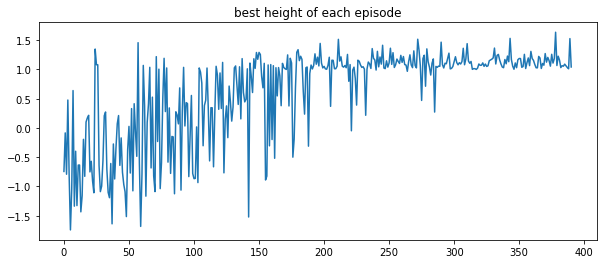

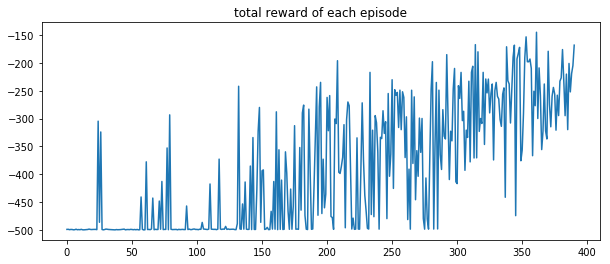

In [16]:
myplot.plot_best_height(best_episode_height)
myplot.plot_total_reward(reward_history)

avg successful steps: 83.5 - 16.7000%
avg first successful step: 106.55 


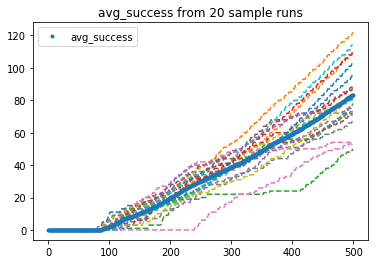

In [17]:
double_avg_success = double_dqn.test_run(env, ddqn, 20, n_steps=500, fps=30, visualization=False)

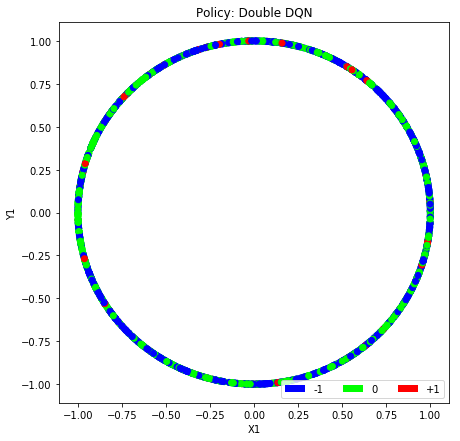

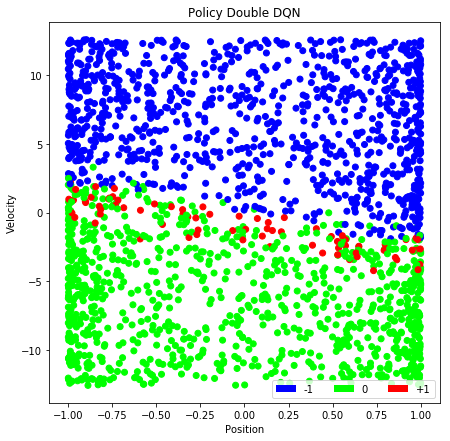

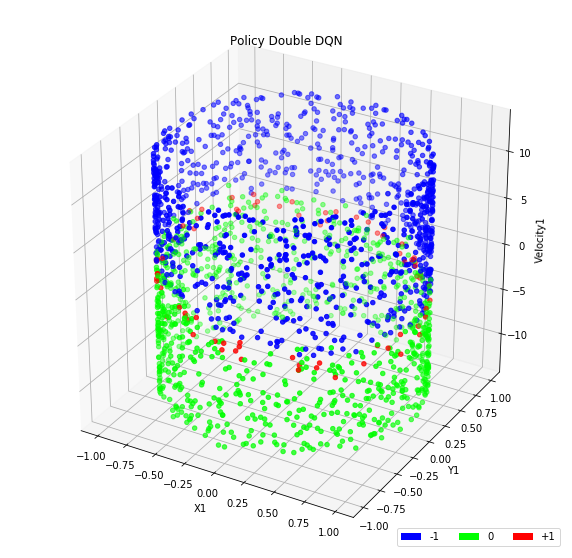

In [18]:
pseudo_states = myplot.prepare_plot_vars(ddqn.offline_model, n_samples=2000)
fig1 = myplot.plot_top_down(*pseudo_states,"Double DQN")
fig2 = myplot.plot_side(*pseudo_states,"Double DQN")
fig3 = myplot.plot_3D(*pseudo_states,"Double DQN")

## Dueling Deep Q-Network

In [19]:
agent = duel_dqn.Agent(
                gamma=0.99, epsilon=1.0, alpha=5e-4,
                input_dims=[6], n_actions=3, mem_size=100000, eps_min=0.01,
                batch_size=64, eps_dec=1e-3, replace=100
                )

episodes = 500
reward_history = []
best_episode_height = []
successful_episodes = 0

for i in range(episodes):
    terminal = False
    state = env.reset()
    running_reward = 0
    max_height = -2
    while not terminal:
        action = agent.choose_action(state)
        next_state, reward, terminal, info = env.step(action)
        running_reward += reward
        
        #compute height of the current step 
        current_height = get_height(state)
        
        #update max_height
        if current_height > max_height:
            max_height = current_height
        
        agent.store_transition(state, action, reward, next_state, int(terminal))
        agent.learn()
        state = next_state
        
        if get_height(next_state)>1:
            successful_episodes+=1
        
    reward_history.append(running_reward)
    avg_reward = np.mean(reward_history)
    
    #record best height of this episode and its reward
    best_episode_height.append(max_height)
    reward_history.append(running_reward)
    
    print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}'.format(
        i, running_reward, avg_reward, agent.epsilon))
    
    if avg_reward>(-120):
        break
env.reset()
print('successful episodes: {:d} - {:.4f}%'.format(successful_episodes, successful_episodes/(i+1)*100))

Episode: 0, Total Reward (running avg): -500 (-500.00) Epsilon: 0.563
Episode: 1, Total Reward (running avg): -225 (-408.33) Epsilon: 0.337
Episode: 2, Total Reward (running avg): -123 (-314.60) Epsilon: 0.213
Episode: 3, Total Reward (running avg): -215 (-273.00) Epsilon: 0.010
Episode: 4, Total Reward (running avg): -109 (-248.33) Epsilon: 0.010
Episode: 5, Total Reward (running avg): -152 (-226.91) Epsilon: 0.010
Episode: 6, Total Reward (running avg): -161 (-216.08) Epsilon: 0.010
Episode: 7, Total Reward (running avg): -183 (-210.20) Epsilon: 0.010
Episode: 8, Total Reward (running avg): -170 (-206.24) Epsilon: 0.010
Episode: 9, Total Reward (running avg): -155 (-201.63) Epsilon: 0.010
Episode: 10, Total Reward (running avg): -142 (-196.57) Epsilon: 0.010
Episode: 11, Total Reward (running avg): -119 (-190.83) Epsilon: 0.010
Episode: 12, Total Reward (running avg): -114 (-184.88) Epsilon: 0.010
Episode: 13, Total Reward (running avg):  -92 (-178.81) Epsilon: 0.010
Episode: 14, Tot

0

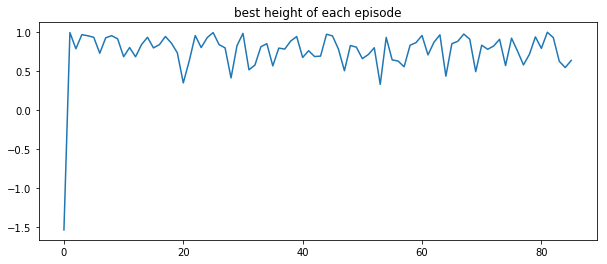

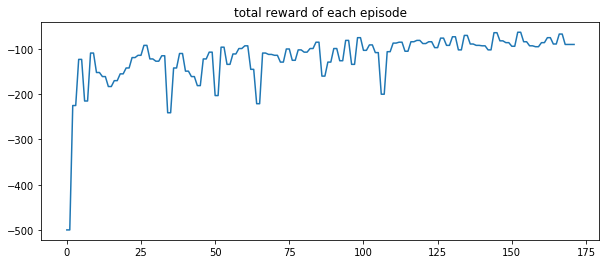

In [20]:
myplot.plot_best_height(best_episode_height)
myplot.plot_total_reward(reward_history)

avg successful steps: 85.65 - 17.1300%
avg first successful step: 75.2 


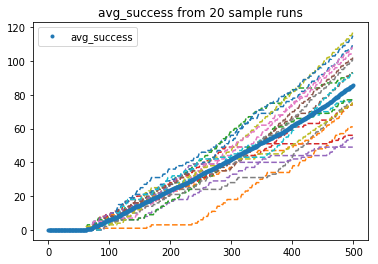

In [21]:
dueling_avg_success = duel_dqn.test_run(env, agent, 20, 500, fps=20, visualization=False)

In [22]:
env.close()

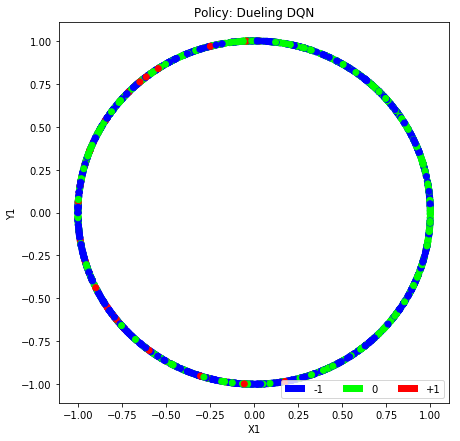

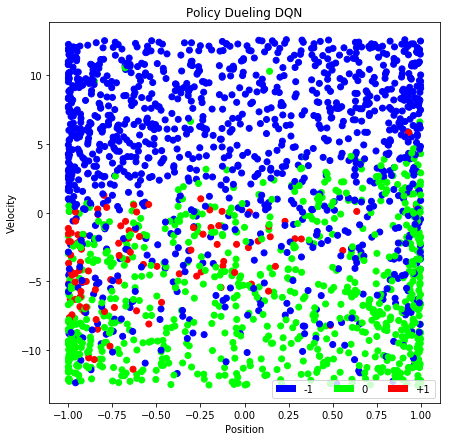

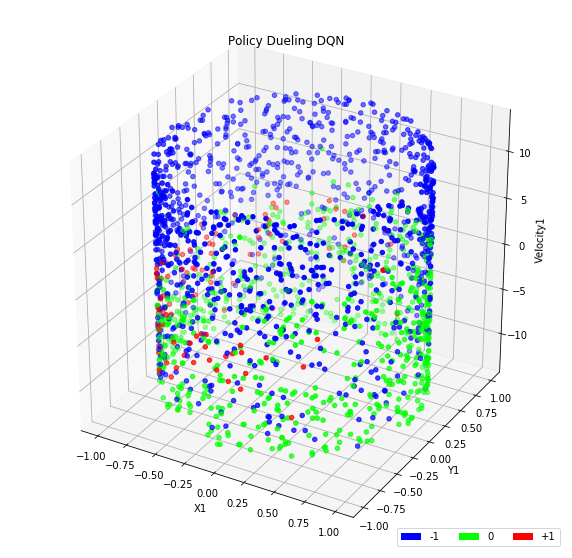

In [23]:
pseudo_states = myplot.prepare_plot_vars_agent(agent, n_samples=2000)
fig1 = myplot.plot_top_down(*pseudo_states,"Dueling DQN")
fig2 = myplot.plot_side(*pseudo_states,"Dueling DQN")
fig3 = myplot.plot_3D(*pseudo_states,"Dueling DQN")

## Performance comparison

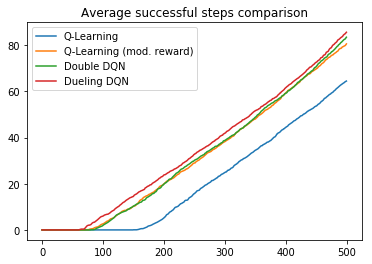

In [24]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(QL_avg_success, label="Q-Learning")
ax.plot(QL2_avg_success, label="Q-Learning (mod. reward)")
ax.plot(double_avg_success, label="Double DQN")
ax.plot(dueling_avg_success, label="Dueling DQN")
ax.set_title("Average successful steps comparison")
ax.legend()